In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis

In [18]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
# general_vals_dict["wx_amps"]=[1.0, .5, 0.5, 1]
print(f"{q1}\n{q2}")
q2.ef_ssm = -0.2962

Qubit(RO_IF=None, ef_amp=1, ge_ssm=-0.114, ge_time=66.83921813916868, qubit_id=q1, qubit_thr=[-10000, -600], ef_ssm=-0.257, ge_amp=0.5, ro_amp=0.6, ROIF=0.10272000000000059, ro_dur=4000, ef_time=77, ro_freq=6.72742, RO_LO_pwr=16, RO_LO=6.6247, IQ_angle=205)
Qubit(RO_IF=None, ef_amp=1, ge_ssm=-0.154, ge_time=23.610582067254867, qubit_id=q2, qubit_thr=[-10000, 1900], ef_ssm=-0.224, ge_amp=1, ro_amp=0.4, ROIF=0.030899999999999928, ro_dur=4000, ef_time=None, ro_freq=6.6556, RO_LO_pwr=16, RO_LO=6.6247, IQ_angle=85)


In [19]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [20]:
def run_rabi(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ef(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.964362 sec
Captured 9 buffers (2.270227 buffers per sec)
Captured 27648 records (6974.136231 records per sec)
Transferred 452984832 bytes (114264248.001302 bytes per sec)


<Figure size 800x800 with 0 Axes>

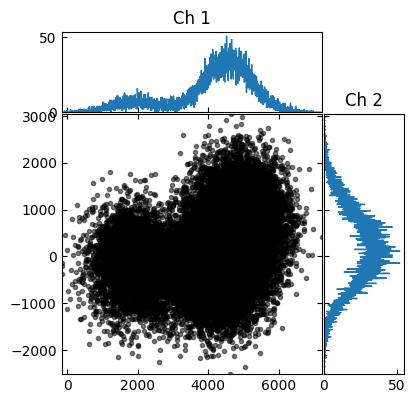

<Figure size 800x800 with 0 Axes>

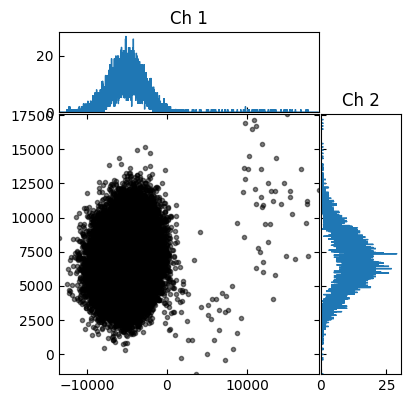

In [26]:
num_steps = 51
reps = 500 
sweep_time = 500
q2.ef_amp = 0.8
values, IQ_df = run_rabi(q2, q1, general_vals_dict, num_steps, sweep_time, reps)

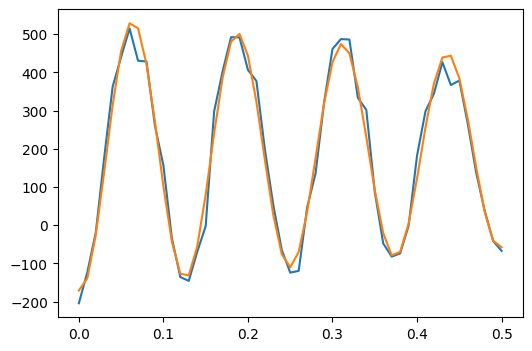



  freq: 8.060252724073166 +/- 0.02729903427029037
 gamma: 0.7521725618775901 +/- 0.15504067739391852
   amp: -361.8861359783638 +/- 14.734710597268204
 phase: 84.9170580769062 +/- 2.5561006186761164
offset: 189.2164072922522 +/- 5.107454507725861
pi_pulse time: 0.062032794394482726 +/- 0.02729903427029037
π_ge time = 62.03279439448273 ns


In [27]:
plotting.rabi_plot(sweep_time, num_steps, values)